# Model Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## import

In [7]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos
from my_helpers.data_plots import load_data_pos
from my_helpers.data_plots import get_old_data_pos
from my_helpers.data_plots import load_old_data_pos
from my_helpers.data_plots import PATH_DF_GOUV_FR_OLD
from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

## Definitions

In [8]:
mode_train = False

In [9]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_SINGLE_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_single_step_pos_fr"
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
nb_period_plot = 15
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

##  Helper functions

In [10]:
# FOR MODEL
"""def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)"""

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [11]:
if mode_train:
    get_data_pos()
    df_feat_fr = load_data_pos()

## Retrieve old data

In [12]:
if mode_train:
    if not os.path.isfile(PATH_DF_GOUV_FR_OLD):
        get_old_data_pos()

    df_feat_fr_old = load_old_data_pos()

## Train/Test split

In [13]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-02-01  284.981667  2021-02-01  288.285000  77.066667  91.583333     0.0   
2021-02-02  285.051667  2021-02-02  290.508333  72.416667  92.083333     0.0   
2021-02-03  284.618333  2021-02-03  289.940000  70.550000  92.516667     0.0   
2021-02-04  283.720000  2021-02-04  289.425000  73.016667  93.150000     0.0   
2021-02-05  284.561667  2021-02-05  289.328333  73.350000  92.766667     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    881  61.023837   39048  55.435003        3    141108        NaN   
2020-05-14    979  60.426966   41986  54.831611        4    142087        NaN   
2020-05-15   1021  60.042116   47686  54.385124        5    143108        NaN   
2020-05-16    291  60.158076   16535  54.486302        6    143399        NaN   
2020-05-17    139  61.568345    6604  58.291036        0    143538        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2021-02-01  31742  48.571514  442528  48.829875        1   3180402   285778.0   
2021-02-02  24218  48.411760  384808  47.747105        2   3204620   285975.0   
2021-02-03  21832  46.989190  349621  46.933634        3   3226452   285181.0   
2021-02-04  21541  47.692772  375476  46.108662        4   3247993   283629.0   
2021-02-05  22231  46.272637  416574  45.878557        5   3270224   281574.0   

                  Rt  rate_pos  
date                            
2020-05-13       NaN  2.256198  
2020-05-14       NaN  2.331730  
2020-05-15       NaN  2.141090  
2020-05-16       NaN  1.759903  
2020-05-17       NaN  2.104785  
...              ...       ...  
2021-02-01  1.112029  7.172879  
2021-02-02  1.108439  6.293528  
2021-02-03  1.095758  6.244476  
2021-02-04  1.075746  5.736985  
2021-02-05  1.052684  5.336627  

[269 rows x 15 columns]

In [14]:
if mode_train:
    # keep 25 Validation samples:
    TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    #TRAIN_SPLIT = 45
else:
    from my_helpers.model import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 223


In [15]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-02-01  284.981667  2021-02-01  288.285000  77.066667  91.583333     0.0   
2021-02-02  285.051667  2021-02-02  290.508333  72.416667  92.083333     0.0   
2021-02-03  284.618333  2021-02-03  289.940000  70.550000  92.516667     0.0   
2021-02-04  283.720000  2021-02-04  289.425000  73.016667  93.150000     0.0   
2021-02-05  284.561667  2021-02-05  289.328333  73.350000  92.766667     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    881  61.023837   39048  55.435003        3    141108        NaN   
2020-05-14    979  60.426966   41986  54.831611        4    142087        NaN   
2020-05-15   1021  60.042116   47686  54.385124        5    143108        NaN   
2020-05-16    291  60.158076   16535  54.486302        6    143399        NaN   
2020-05-17    139  61.568345    6604  58.291036        0    143538        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2021-02-01  31742  48.571514  442528  48.829875        1   3180402   285778.0   
2021-02-02  24218  48.411760  384808  47.747105        2   3204620   285975.0   
2021-02-03  21832  46.989190  349621  46.933634        3   3226452   285181.0   
2021-02-04  21541  47.692772  375476  46.108662        4   3247993   283629.0   
2021-02-05  22231  46.272637  416574  45.878557        5   3270224   281574.0   

                  Rt  rate_pos  train  
date                                   
2020-05-13       NaN  2.256198   True  
2020-05-14       NaN  2.331730   True  
2020-05-15       NaN  2.141090   True  
2020-05-16       NaN  1.759903   True  
2020-05-17       NaN  2.104785   True  
...              ...       ...    ...  
2021-02-01  1.112029  7.172879  False  
2021-02-02  1.108439  6.293528  False  
2021-02-03  1.095758  6.244476  False  
2021-02-04  1.075746  5.736985  False  
2021-02-05  1.052684  5.336627  False  

[269 rows x 16 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

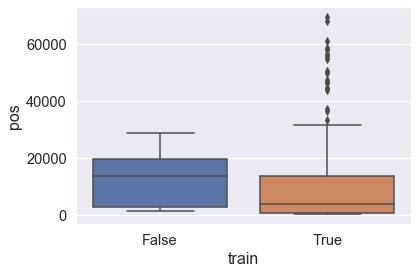

In [12]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

#### First wave

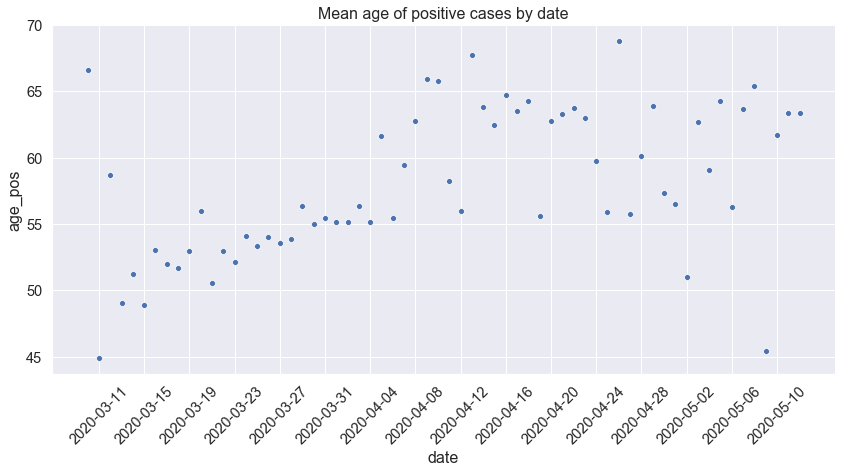

In [13]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr_old, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr_old["date"].min(), 
                    df_feat_fr_old["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

#### Second wave

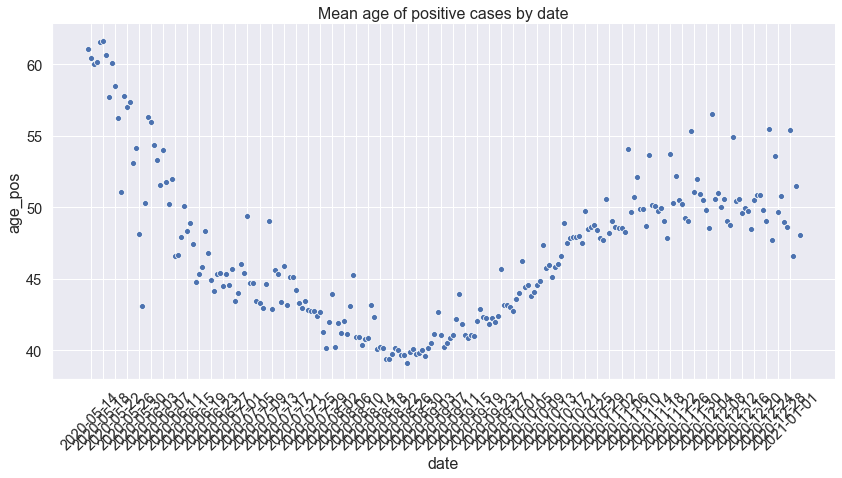

In [14]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

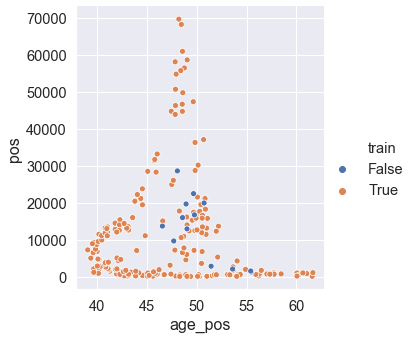

In [15]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

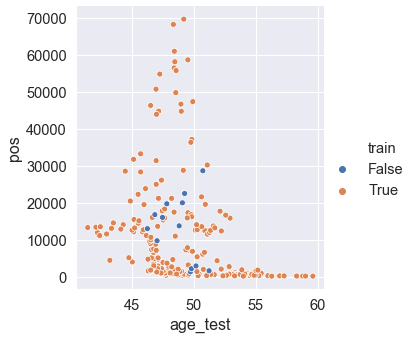

In [16]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

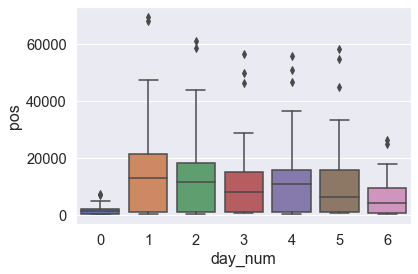

In [17]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [18]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

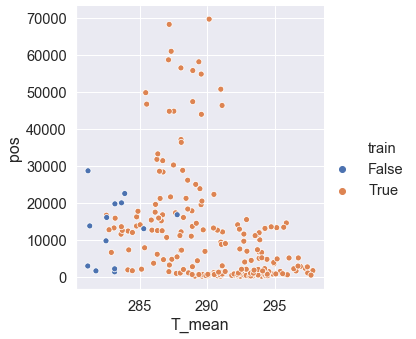

In [19]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

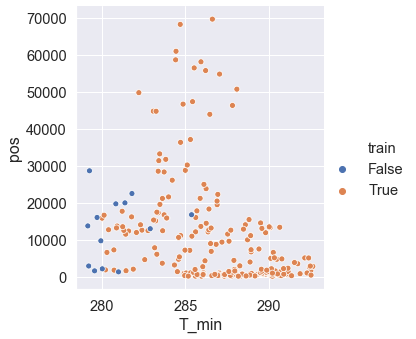

In [20]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

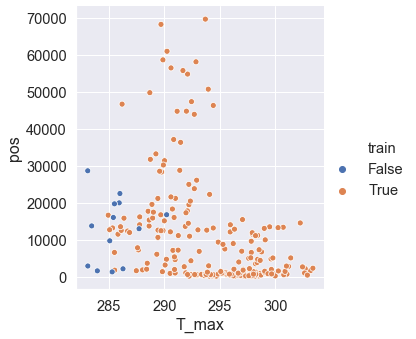

In [21]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

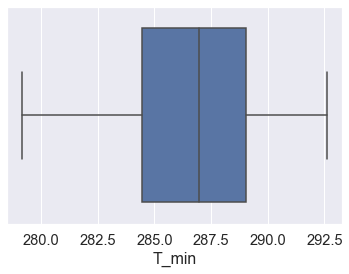

In [22]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [23]:
df_feat_fr["T_min"].mean()

286.6040338631314

In [24]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

False    126
True     111
Name: T_min, dtype: int64

In [25]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

False    119
True     118
Name: T_min, dtype: int64

In [26]:
df_feat_fr["T_min"].median()

286.94661016949163

In [27]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

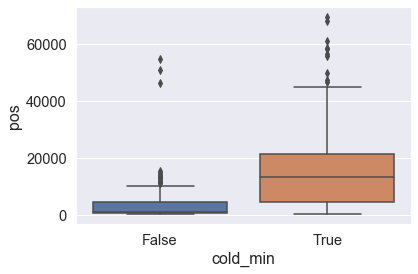

In [28]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then more positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

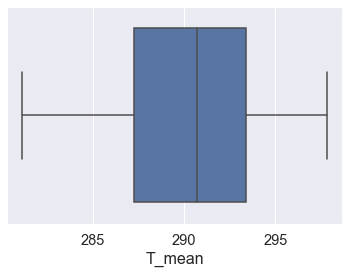

In [29]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [30]:
df_feat_fr["T_mean"].median()

290.70000000000005

In [31]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

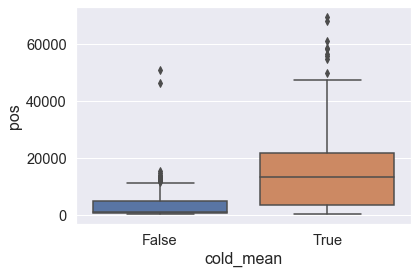

In [32]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

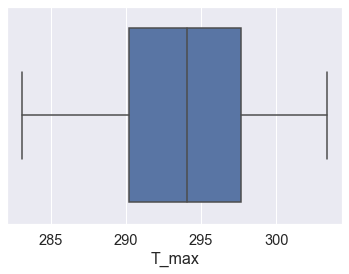

In [33]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [34]:
df_feat_fr["T_max"].median()

294.05877192982456

In [35]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

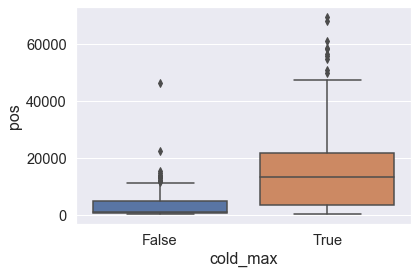

In [36]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [37]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

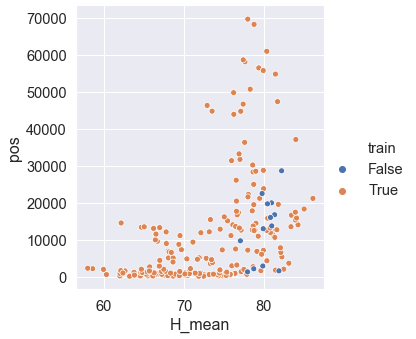

In [38]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

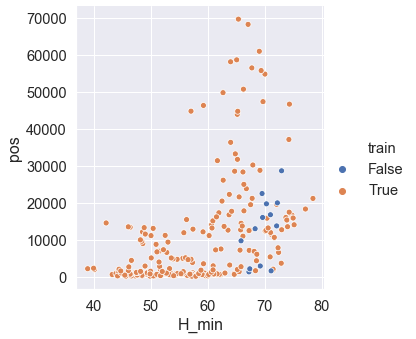

In [39]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

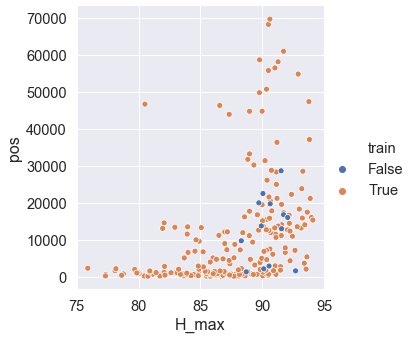

In [40]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

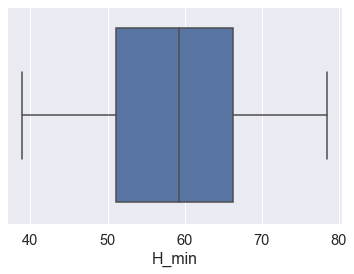

In [41]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [42]:
df_feat_fr["H_min"].median()

59.25862068965517

In [43]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

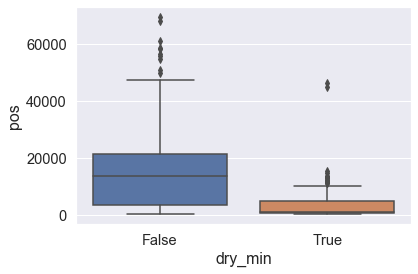

In [44]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> more DRY, less positive cases

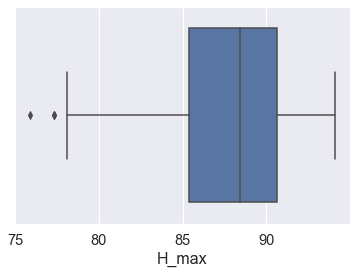

In [45]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [46]:
df_feat_fr["H_max"].median()

88.42372881355931

In [47]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

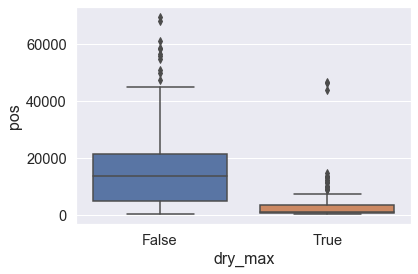

In [48]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> => Same than H min

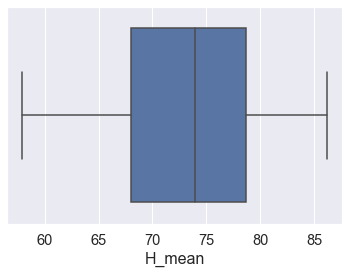

In [49]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [50]:
df_feat_fr["H_mean"].median()

73.98305084745763

In [51]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

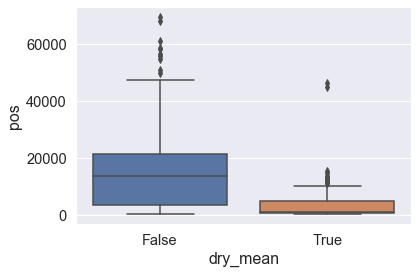

In [52]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Same H min

### Seasonality impact

In [53]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

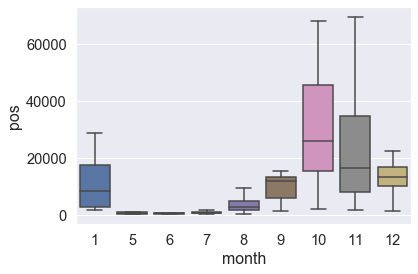

In [54]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

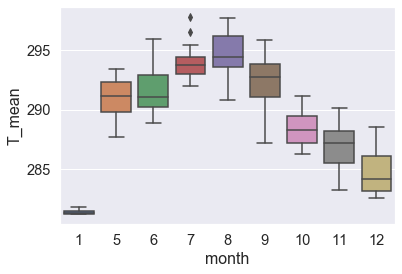

In [55]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

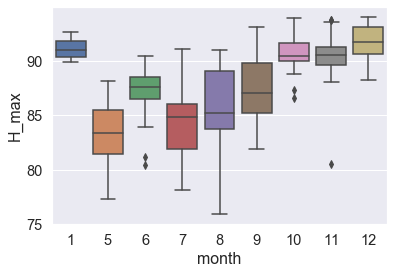

In [56]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [57]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
1       46813
5       11838
6       14892
7       24757
8      105823
9      293328
10     932516
11     670573
12     395238

### Nb Tested

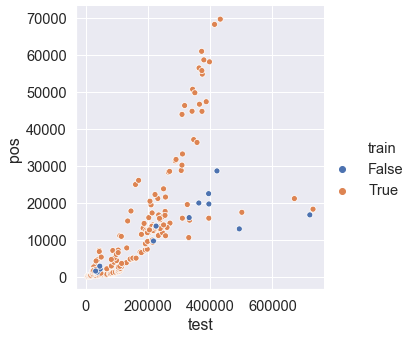

In [58]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [59]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [60]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=100*df_feat_fr_old["pos"] / df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

### Rt

In [66]:
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2020-12-31  279.726271  2020-12-31  285.392373  69.610169  92.050847     0.0   
2021-01-01  279.578333  2021-01-01  283.950000  71.100000  92.683333     0.0   
2021-01-02  279.173333  2021-01-02  283.438333  72.066667  89.916667     0.0   
2021-01-03  279.226271  2021-01-03  283.090678  69.203390  90.542373     0.0   
2021-01-04  279.273333  2021-01-04  283.083333  72.933333  91.516667     0.0   

              pos    age_pos    test   age_test  ...  train      T_mean  \
date                                             ...                      
2020-05-13    881  61.023837   39034  55.429856  ...   True  287.715833   
2020-05-14    979  60.426966   41971  54.826499  ...   True  288.006667   
2020-05-15   1021  60.042116   47665  54.380069  ...   True  288.614167   
2020-05-16    291  60.158076   16523  54.488471  ...   True  289.228333   
2020-05-17    139  61.568345    6603  58.292443  ...   True  290.022500   
...           ...        ...     ...        ...  ...    ...         ...   
2020-12-31  16015  48.586263  332662  47.453568  ...  False  282.559322   
2021-01-01   1562  55.415493   32334  51.218346  ...  False  281.764167   
2021-01-02  13727  46.572886  226475  48.801766  ...  False  281.305833   
2021-01-03   2876  51.449930   45631  50.162587  ...  False  281.158475   
2021-01-04  28648  48.073792  421912  50.712843  ...  False  281.178333   

            cold_min  cold_mean  cold_max     H_mean  dry_min  dry_max  \
date                                                                     
2020-05-13      True       True      True  76.398305    False     True   
2020-05-14      True       True      True  72.127119    False     True   
2020-05-15      True       True      True  70.169492     True     True   
2020-05-16      True       True      True  70.137931     True     True   
2020-05-17      True       True     False  67.689655     True     True   
...              ...        ...       ...        ...      ...      ...   
2020-12-31      True       True      True  80.830508    False    False   
2021-01-01      True       True      True  81.891667    False    False   
2021-01-02      True       True      True  80.991667    False    False   
2021-01-03      True       True      True  79.872881    False    False   
2021-01-04      True       True      True  82.225000    False    False   

            dry_mean  month  
date                         
2020-05-13     False      5  
2020-05-14      True      5  
2020-05-15      True      5  
2020-05-16      True      5  
2020-05-17      True      5  
...              ...    ...  
2020-12-31     False     12  
2021-01-01     False      1  
2021-01-02     False      1  
2021-01-03     False      1  
2021-01-04     False      1  

[237 rows x 25 columns]

In [68]:
# Create figure 
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_feat_fr["date"], 
                         y=df_feat_fr["Rt"],
                    mode='lines+markers',
                    line_shape='linear',
                    name="Rt"))
fig.update_layout(title='COVID-19 Reproduction number Rt (France)',
                 yaxis_title='Rt [-]')
fig.show()

## Prepare features

In [16]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [17]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max    pos    test  \
date                                                                      
2020-05-13  284.926667  290.505000  64.661017  88.135593    881   39048   
2020-05-14  285.050000  290.963333  59.406780  84.847458    979   41986   
2020-05-15  285.308333  291.920000  57.372881  82.966102   1021   47686   
2020-05-16  284.956667  293.500000  53.741379  86.534483    291   16535   
2020-05-17  285.598333  294.446667  49.879310  85.500000    139    6604   
...                ...         ...        ...        ...    ...     ...   
2021-02-01  284.981667  288.285000  77.066667  91.583333  31742  442528   
2021-02-02  285.051667  290.508333  72.416667  92.083333  24218  384808   
2021-02-03  284.618333  289.940000  70.550000  92.516667  21832  349621   
2021-02-04  283.720000  289.425000  73.016667  93.150000  21541  375476   
2021-02-05  284.561667  289.328333  73.350000  92.766667  22231  416574   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  61.023837  55.435003  
2020-05-14        4  60.426966  54.831611  
2020-05-15        5  60.042116  54.385124  
2020-05-16        6  60.158076  54.486302  
2020-05-17        0  61.568345  58.291036  
...             ...        ...        ...  
2021-02-01        1  48.571514  48.829875  
2021-02-02        2  48.411760  47.747105  
2021-02-03        3  46.989190  46.933634  
2021-02-04        4  47.692772  46.108662  
2021-02-05        5  46.272637  45.878557  

[269 rows x 9 columns]

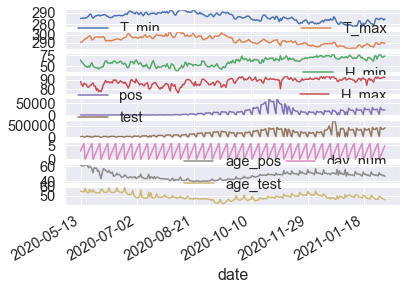

In [18]:
features.plot(subplots=True);

In [19]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [20]:
dataset.shape

(269, 9)

## Multi-step model

### Helper functions

In [21]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [22]:
TRAIN_SPLIT

223

In [23]:
dataset.shape

(269, 9)

In [24]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [25]:
y_train_multi.shape

(209, 7)

In [26]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

209 Single window of past history : (14, 9)

 209 Target temperature to predict : (7,)


In [27]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 209
BUFFER_SIZE : 223

For validation : 
BATCH_SIZE_VAL : 39


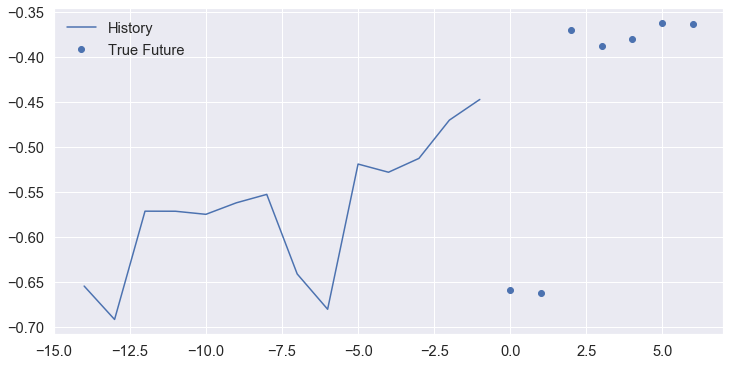

In [28]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [29]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 209
nb samples for validation : 39


In [30]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    NB_TRY = 500
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000

    # Hyper-parameters
    # lr=6e-2 : err=1.23 mais diverge
    # lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
    # lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
    # lr=2e-2 : err=1.18 Final val_loss = 1.181 people : 321 (juil 2020)
    # lr=2e-2 : err= 1.83 Mean asbolute Error in people : 484 (aout 2020)
    # lr=2e-2 : Final val_loss = 1.7202385663986206 / 453.984980383009 / 45min 10s / mid-august
    # lr=2e-2 : Final val_loss = 5.082364559173584 Mean asbolute Error in people : 1540.5864920799772
    # lr=2e-2 : Final val_loss = 4.183023452758789 Mean asbolute Error in people : 1630.9316293070544 Wall time: 2h 23min 11s
    # lr=2e-2 : nb samples for training : 121 / nb samples for validation : 7
    # Final val_loss = 0.861526608467102 Mean asbolute Error in people : 3446.437551562592 Wall time: 2h 39min 39s
    # Final val_loss = 1.6073311567306519 Mean asbolute Error in people : 8765.89918940898 Wall time:3h28 patience=100
    # Final val_loss = 1.2980750799179077 Mean asbolute Error in people : 7079.309850490991 Wall time: 6h 31min 34s patience=250
    # 2021-01-08 : 2min 10epochs 5000people patience 250
    # 2021-01-08 : Final val_loss = 0.3031 Mean asbolute Error in people : 4429 Wall time: 1h 26min 5s
    lr = 2e-2
    decay = 1e-6 #1e-6
    momentum = 0.9 # 0.9
    nesterov = True # True
    patience = 250 # 30

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=sgd_2, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


### Eval

In [31]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a493cf7d0> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a49438510>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a49438d90> and <tensorflow.python.keras.layers.core.Dense object at 0x1a49471350>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a49438d90> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a49438510>).
CPU times: user 2.14 s, sys: 128 ms, total: 2.27 s
Wall time: 2.49 s


In [32]:
%%time 
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)
print("Mean error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Mean nb cases  [nb of cases]: ", mean_val)
print("mean relative error [%]: ", 100*mean_error_val/mean_val)

Mean error  [nb of cases]:  5801.3830682075995
Mean nb cases  [nb of cases]:  17796.08791208791
mean relative error [%]:  32.59920436933241
CPU times: user 681 ms, sys: 39.5 ms, total: 720 ms
Wall time: 905 ms


In [33]:
multi_step_model.predict(x_val_multi)

array([[ 0.6796996 ,  0.6439974 ,  0.18541768, -0.24197178, -0.64746237,
        -0.44432235,  0.5243244 ],
       [ 0.42287916,  0.23161878, -0.1377284 , -0.187314  ,  0.06793614,
         0.36327532,  0.5842658 ],
       [ 0.1519894 ,  0.04764635, -0.04318221,  0.05665875,  0.47401413,
         0.7162794 ,  0.53566265],
       [-0.05102051,  0.00587224,  0.33930942,  0.45494133,  0.73190105,
         0.85217166,  0.4747294 ],
       [ 0.04437655,  0.02684649,  0.3438679 ,  0.44631982,  0.53851503,
         0.43594232,  0.12844846],
       [-0.4111253 , -0.19081645,  0.62845874,  0.7150319 ,  0.5579245 ,
         0.36627898, -0.04248732],
       [ 0.7266952 ,  0.6087214 ,  0.6415193 ,  0.71217996,  0.6354732 ,
         0.0536576 , -0.23421988],
       [ 0.7599586 ,  0.6933309 ,  0.6403584 ,  0.37135443,  0.04576907,
         0.17600337,  0.8775884 ],
       [ 0.9089877 ,  0.5920604 ,  0.35706195,  0.28110924,  0.5047118 ,
         0.9015748 ,  1.3136641 ],
       [ 0.72288126,  0.3659

In [34]:
y_val_multi_pred.shape[0]

39

In [35]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

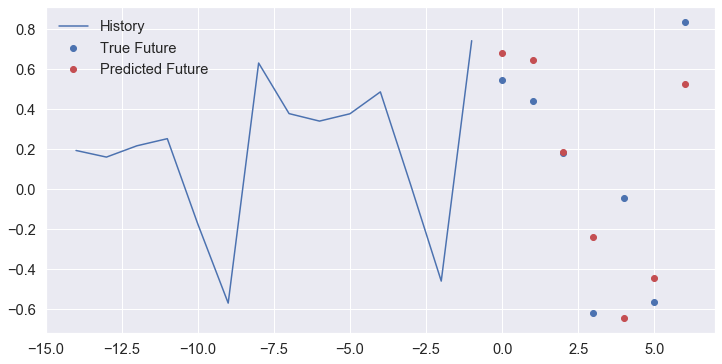

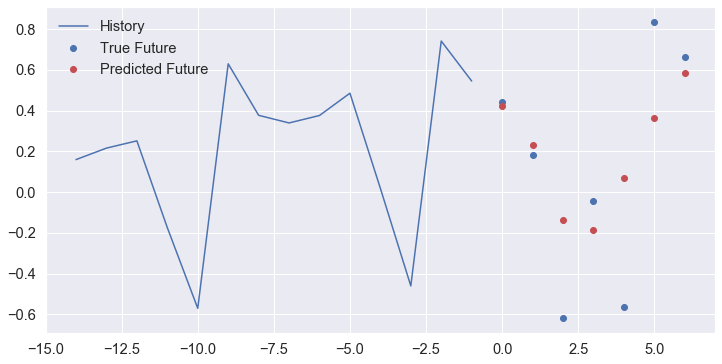

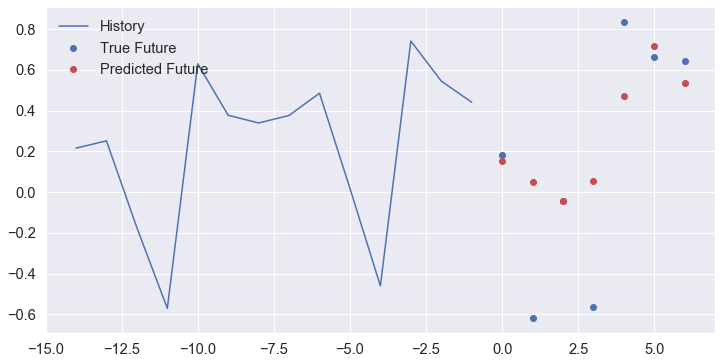

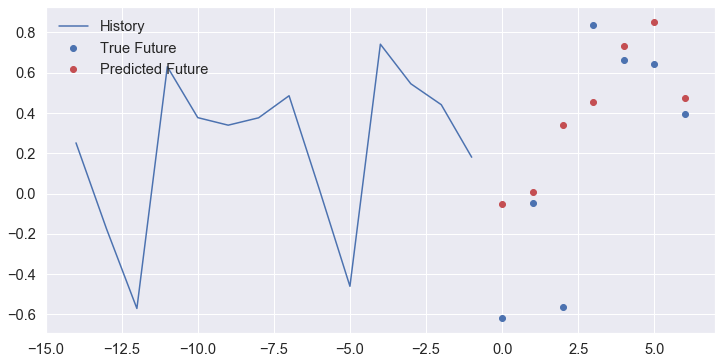

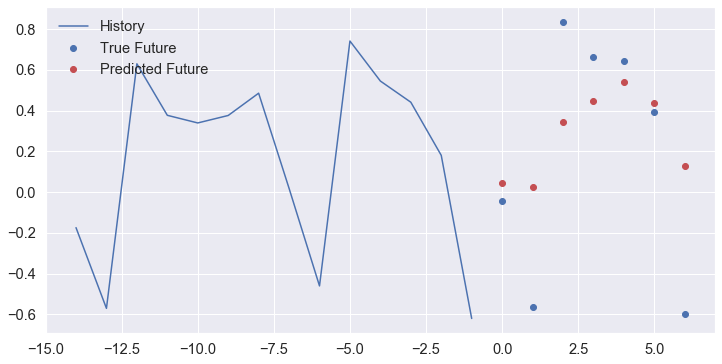

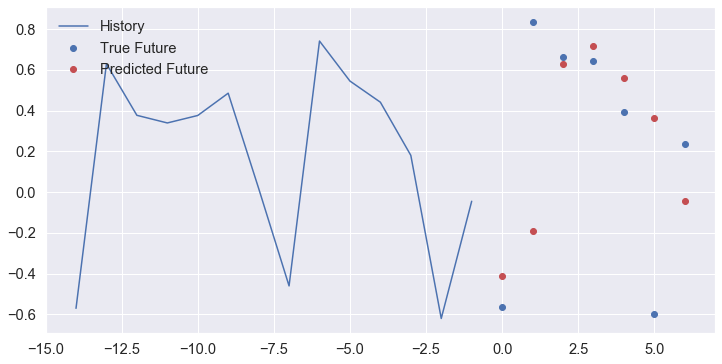

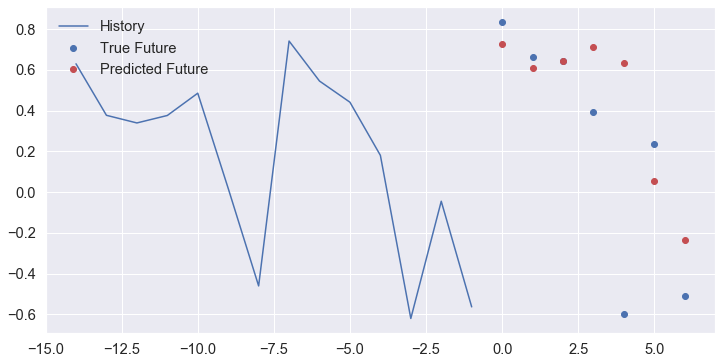

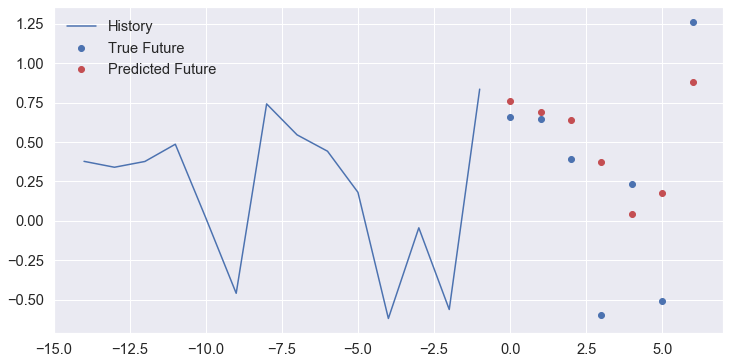

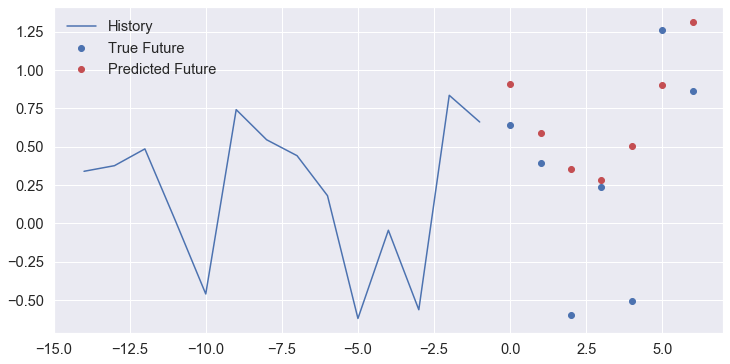

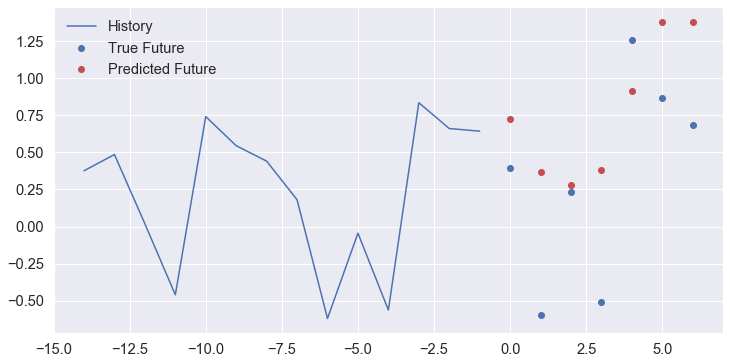

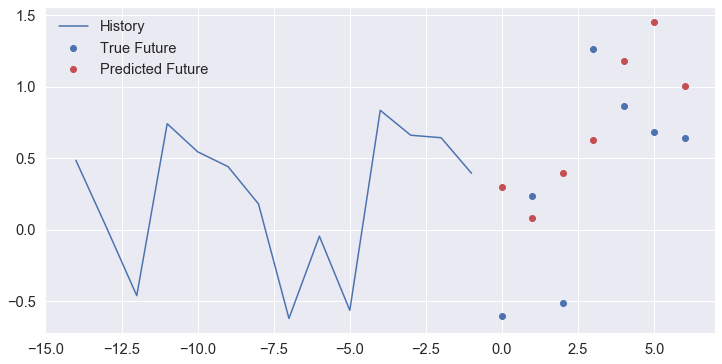

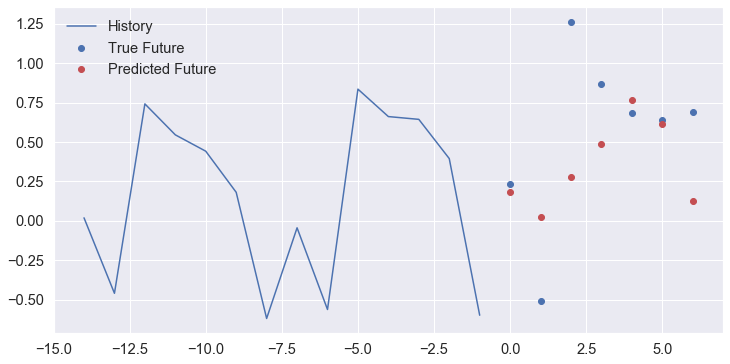

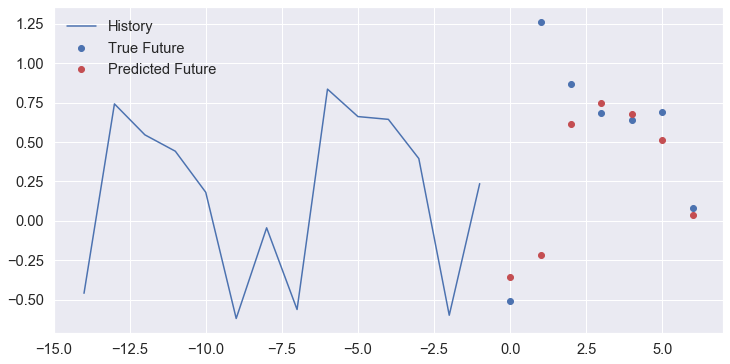

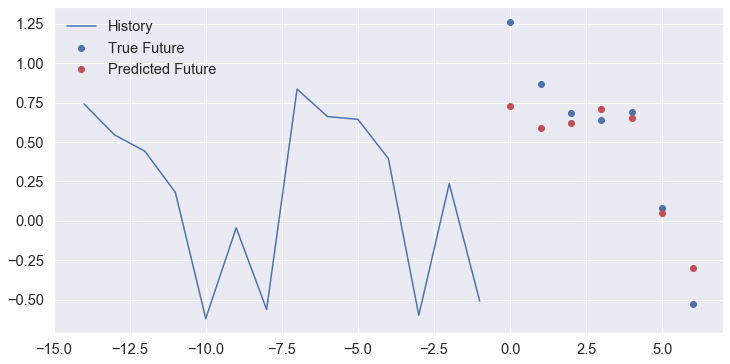

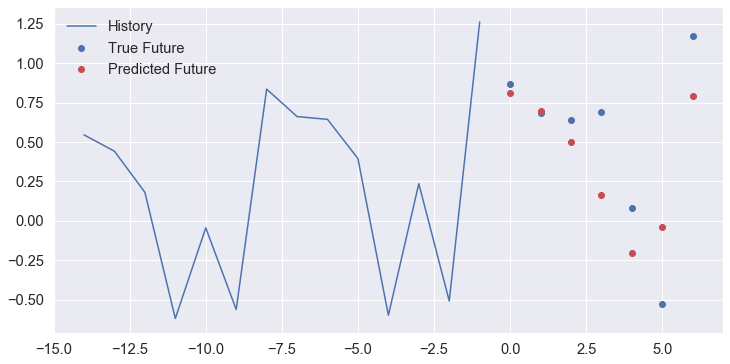

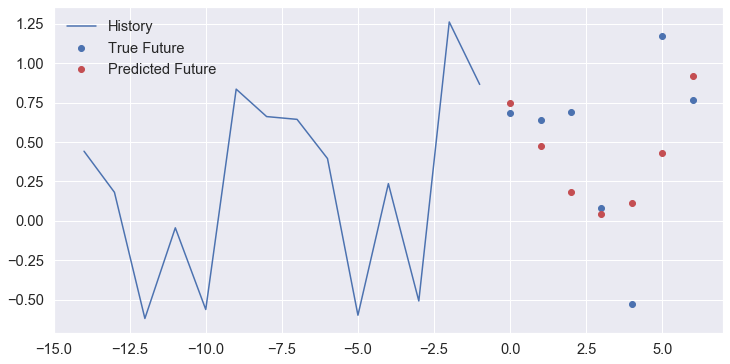

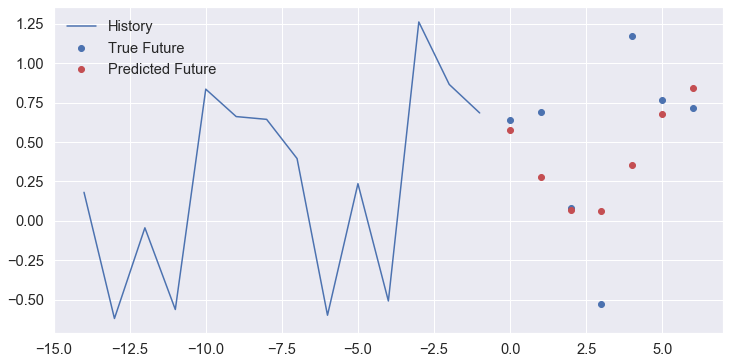

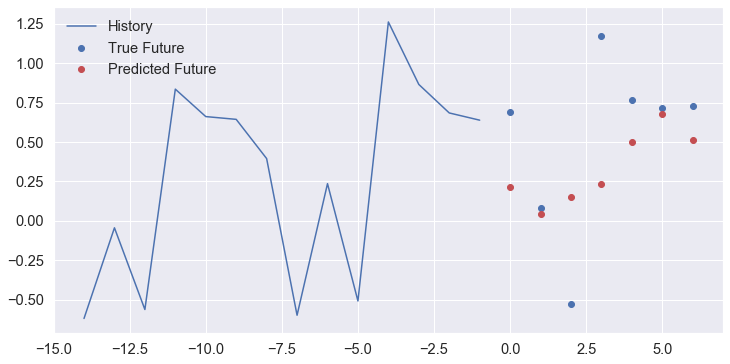

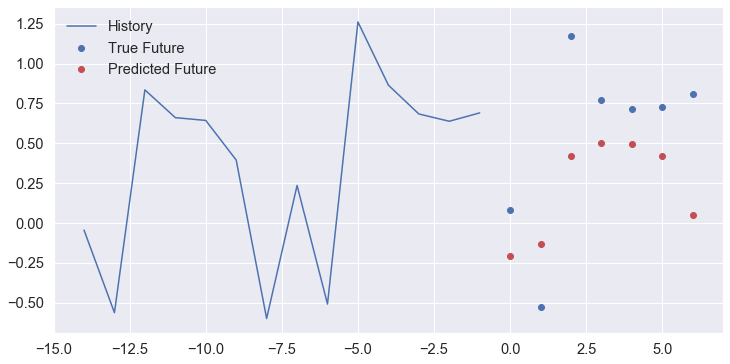

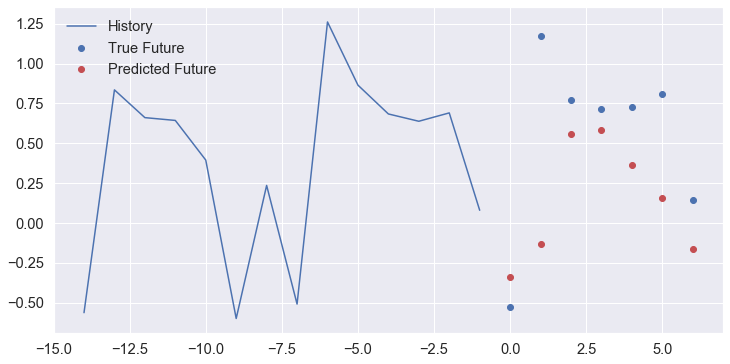

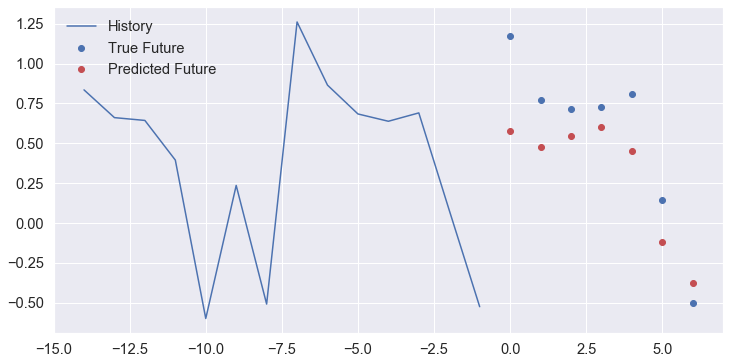

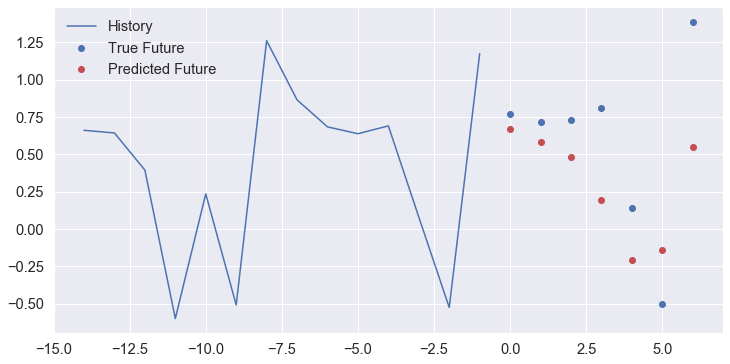

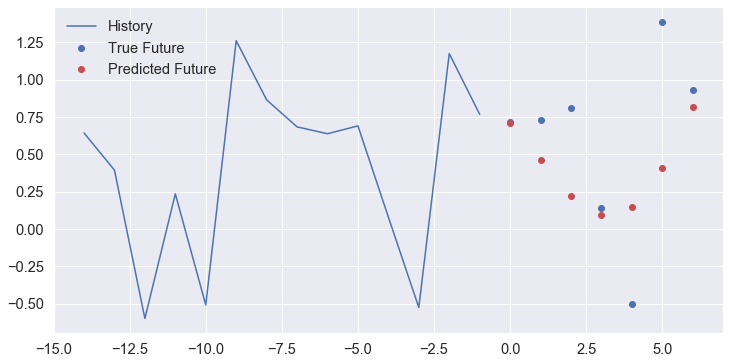

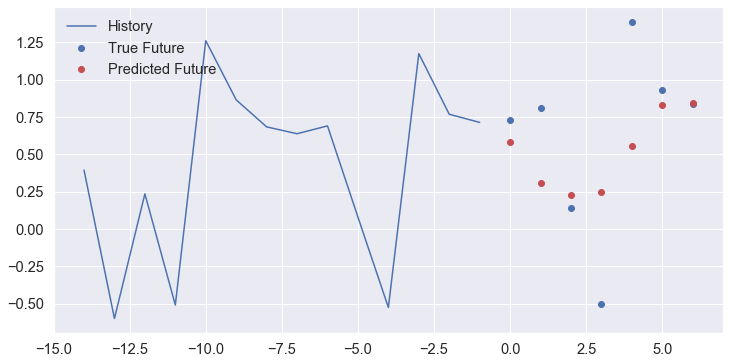

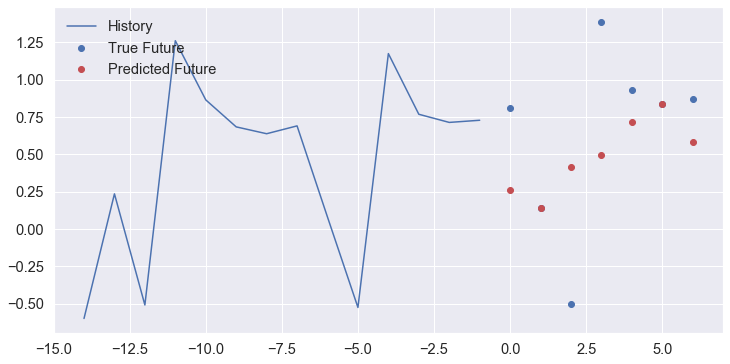

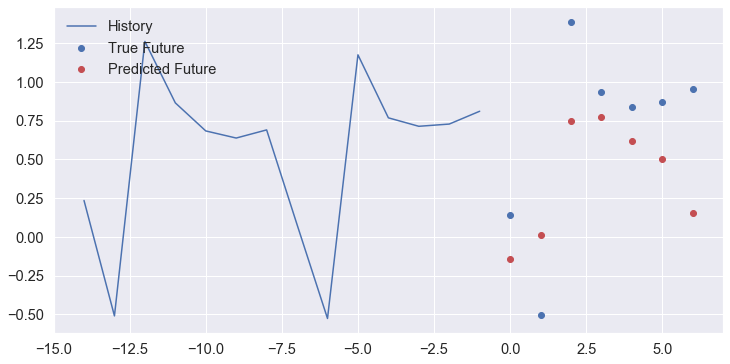

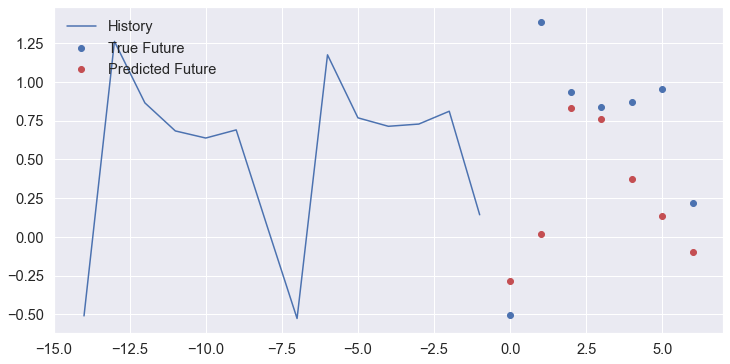

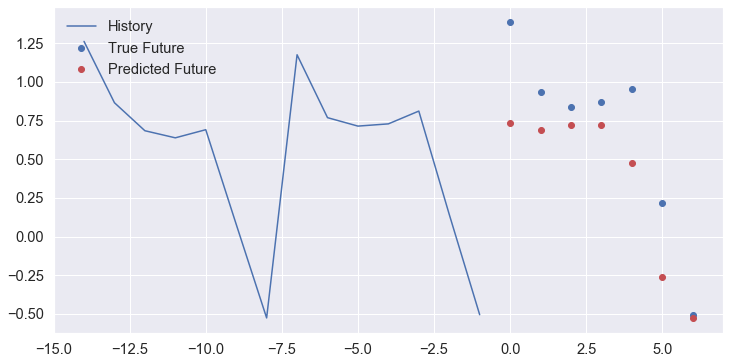

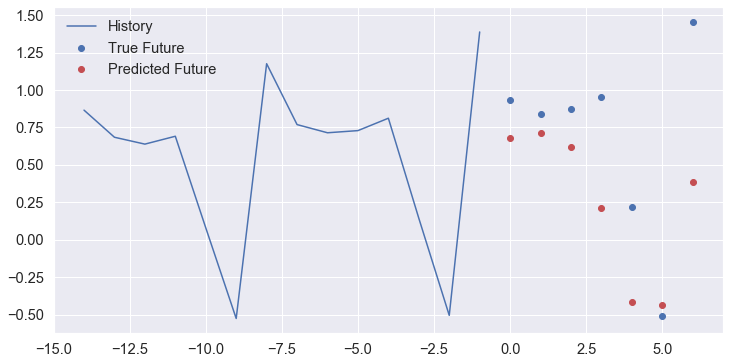

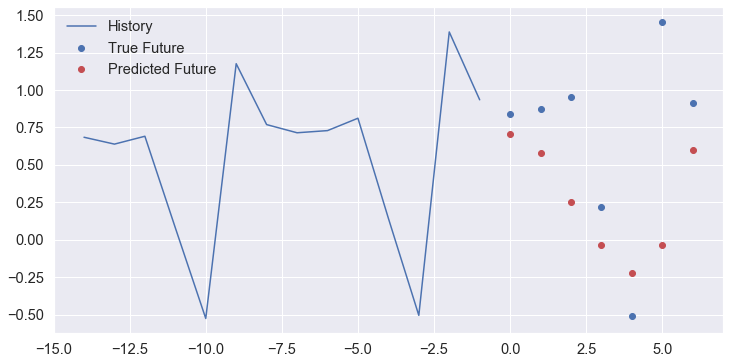

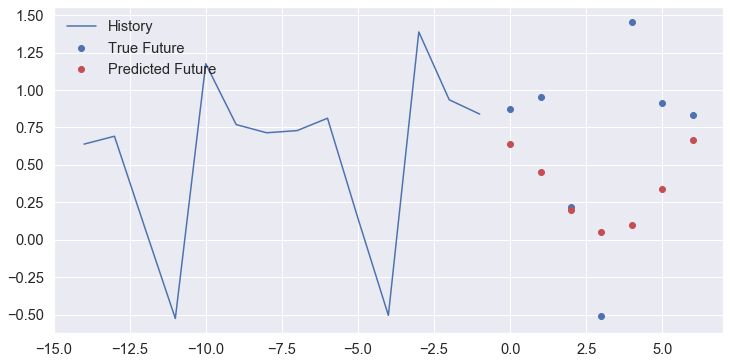

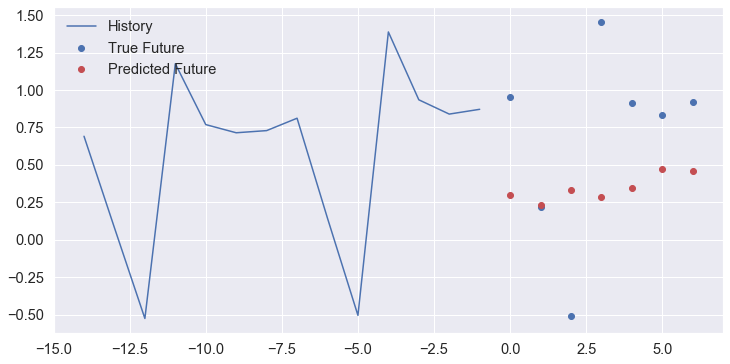

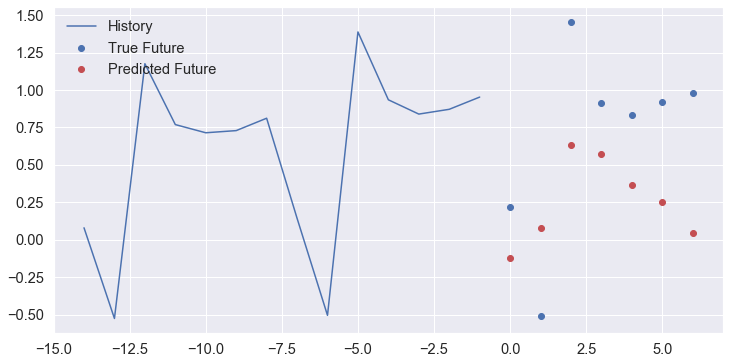

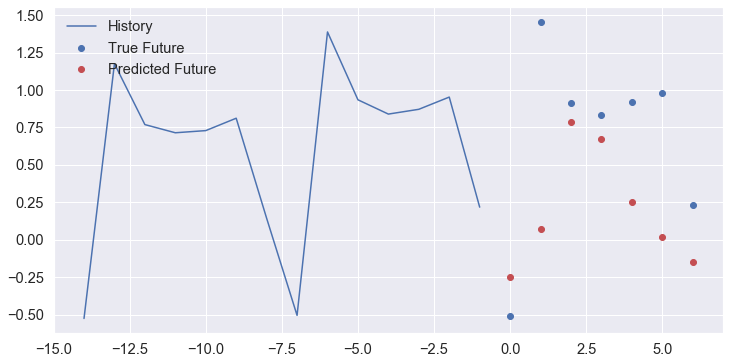

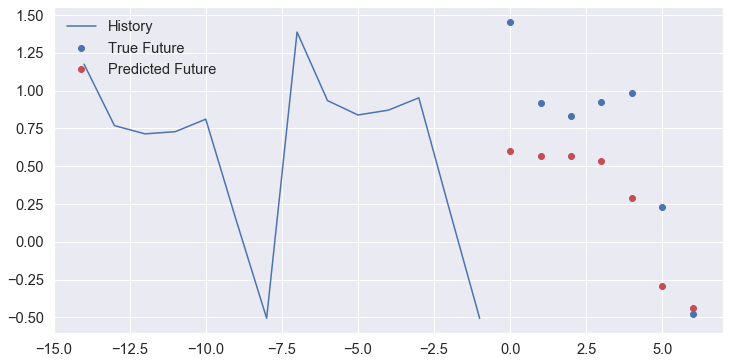

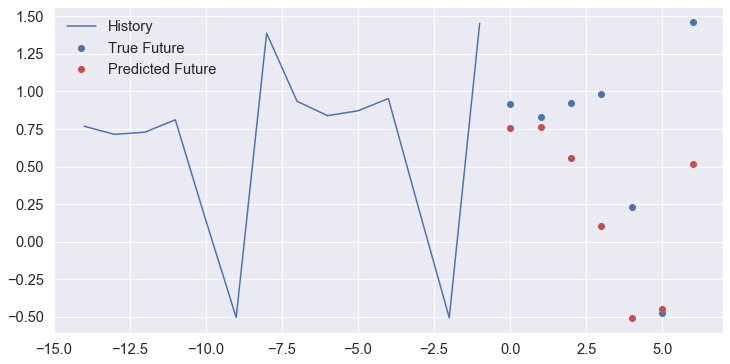

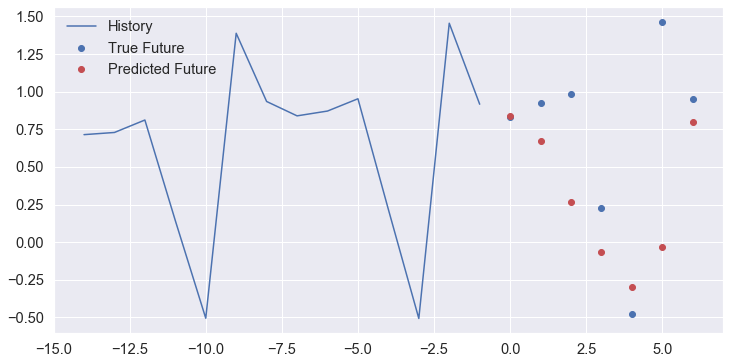

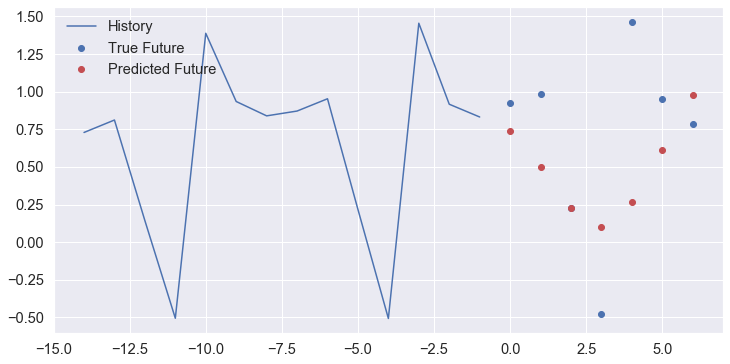

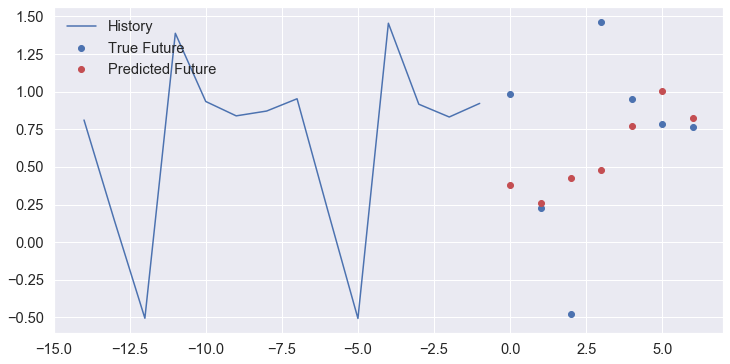

In [36]:
for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [52]:
nb_period_plot = 23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [53]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr'

In [54]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a4acc40d0> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a4acc6690>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a4acc6ed0> and <tensorflow.python.keras.layers.core.Dense object at 0x1a4acd0450>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a4acc6ed0> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a4acc6690>).


In [55]:
TRAIN_SPLIT

223

In [56]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [57]:
df_feat_fr.shape

(269, 15)

In [58]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 443 ms, sys: 20.7 ms, total: 464 ms
Wall time: 500 ms


In [59]:
df_feat_fr.date.min()

'2020-05-13'

In [60]:
df_feat_fr.date.max()

'2021-02-05'

In [61]:
df_feat_fr.pos.std()

14080.141238699474

In [62]:
data_std[4]

14619.296788458485

In [63]:
NB_DAY_PLOT

161

In [64]:
str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
str_date_0

'2020-08-28'

In [65]:
# last nth days
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date    pos  nb_cases
2021-02-06  2021-02-06  10822   3281046
2021-02-07  2021-02-07  14711   3295757
2021-02-08  2021-02-08  30862   3326619
2021-02-09  2021-02-09  31557   3358176
2021-02-10  2021-02-10  30273   3388449
2021-02-11  2021-02-11  29822   3418271
2021-02-12  2021-02-12  23151   3441422

In [66]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2020-12-22'

In [67]:
df_plot

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-08-28  289.388333  2020-08-28  295.438333  62.322034  90.610169     0.0   
2020-08-29  288.246667  2020-08-29  293.980000  60.948276  91.034483     0.0   
2020-08-30  287.823333  2020-08-30  293.868333  60.655172  90.051724     0.0   
2020-08-31  287.178333  2020-08-31  294.845000  53.033898  89.220339     0.0   
2020-09-01  286.831667  2020-09-01  295.273333  50.949153  87.779661     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-02-01  284.981667  2021-02-01  288.285000  77.066667  91.583333     0.0   
2021-02-02  285.051667  2021-02-02  290.508333  72.416667  92.083333     0.0   
2021-02-03  284.618333  2021-02-03  289.940000  70.550000  92.516667     0.0   
2021-02-04  283.720000  2021-02-04  289.425000  73.016667  93.150000     0.0   
2021-02-05  284.561667  2021-02-05  289.328333  73.350000  92.766667     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-08-28   7482  39.871692  198080  46.741655        5    284071    63973.0   
2020-08-29   2925  40.074188   82843  46.753160        6    286996    66169.0   
2020-08-30   1216  39.704770   26338  46.992482        0    288212    66715.0   
2020-08-31   9344  39.792915  215945  46.804682        1    297556    71109.0   
2020-09-01   8738  39.988327  193184  46.904148        2    306294    75155.0   
...           ...        ...     ...        ...      ...       ...        ...   
2021-02-01  31742  48.571514  442528  48.829875        1   3180402   285778.0   
2021-02-02  24218  48.411760  384808  47.747105        2   3204620   285975.0   
2021-02-03  21832  46.989190  349621  46.933634        3   3226452   285181.0   
2021-02-04  21541  47.692772  375476  46.108662        4   3247993   283629.0   
2021-02-05  22231  46.272637  416574  45.878557        5   3270224   281574.0   

                  Rt  rate_pos  
date                            
2020-08-28  2.254555  3.777262  
2020-08-29  2.336724  3.530775  
2020-08-30  2.321087  4.616903  
2020-08-31  2.243965  4.327028  
2020-09-01  2.186136  4.523149  
...              ...       ...  
2021-02-01  1.112029  7.172879  
2021-02-02  1.108439  6.293528  
2021-02-03  1.095758  6.244476  
2021-02-04  1.075746  5.736985  
2021-02-05  1.052684  5.336627  

[162 rows x 15 columns]

### Figure

In [68]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [69]:
nb_period_plot

23

In [71]:
dataset.shape

(269, 9)

In [72]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[94 - 108]
[101 - 115]
[108 - 122]
[115 - 129]
[122 - 136]
[129 - 143]
[136 - 150]
[143 - 157]
[150 - 164]
[157 - 171]
[164 - 178]
[171 - 185]
[178 - 192]
[185 - 199]
[192 - 206]
[199 - 213]
[206 - 220]
[213 - 227]
[220 - 234]
[227 - 241]
[234 - 248]
[241 - 255]
[248 - 262]
23
CPU times: user 1.04 s, sys: 63.4 ms, total: 1.1 s
Wall time: 1.23 s


array([[ 3230.2432,  4851.0015,  8405.83  ,  8544.956 ,  8919.843 ,
         9012.207 ,  7169.8643,  4598.3877,  5905.6885,  9446.879 ,
         9916.778 , 11194.004 , 11454.674 ,  8883.979 ,  3493.92  ,
         5747.614 , 11811.503 , 12668.511 , 13495.164 , 12983.127 ,
         8792.631 ,  5536.266 ,  6914.6934, 11719.064 , 11949.843 ,
        12244.537 , 12238.68  , 10342.712 ,  6047.069 ,  7398.9834,
        12568.887 , 13263.368 , 14259.344 , 14479.978 , 11605.324 ,
         9388.365 , 10297.126 , 16454.273 , 17422.357 , 19634.85  ,
        20276.98  , 16012.582 , 12747.28  , 13527.699 , 22546.23  ,
        24303.773 , 28059.938 , 29098.02  , 22284.137 , 20070.363 ,
        18134.98  , 30679.543 , 34446.496 , 42680.63  , 46609.203 ,
        36637.81  , 25093.207 , 25392.857 , 45019.85  , 47471.766 ,
        50522.344 , 50878.36  , 40663.84  , 22370.023 , 23236.04  ,
        41377.38  , 42883.3   , 44217.535 , 43981.984 , 34689.89  ,
        16805.316 , 17823.781 , 30426.285 , 3012

In [73]:
y_pos_pred.shape

(1, 161)

In [74]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

161
2020-08-28
2021-02-05


date    pos  nb_cases
2020-08-29  2020-08-29   3230    287301
2020-08-30  2020-08-30   4851    292152
2020-08-31  2020-08-31   8405    300557
2020-09-01  2020-09-01   8544    309101
2020-09-02  2020-09-02   8919    318020
...                ...    ...       ...
2021-02-01  2021-02-01  23229   3175351
2021-02-02  2021-02-02  23966   3199317
2021-02-03  2021-02-03  23510   3222827
2021-02-04  2021-02-04  22751   3245578
2021-02-05  2021-02-05  16343   3261921

[161 rows x 3 columns]

### Figure all past 

In [75]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [76]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [77]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()